# Physics-informed neural networks (PINNs) 
# Tutorial part 1: preliminary
#### Thi Nguyen Khoa Nguyen, Thibault Dairay, Raphaël Meunier, Christophe Millet, and Mathilde Mougeot

The objective of this preliminary section is to see how the data-driven machine learning method approximate the solution of the PDE.

We illustrate the use of the following data-driven methods in this section:
* Random forest regression
* Gradient boosting regression
* Gaussian process
* (Data-driven) Neural networks 

## Data driven machine learning
In data-driven machine learning methods, to predict the solution of a PDE, we use a function $\mathcal{F}$ to approximate the supervised data inside the domain. We take an example of Burgers equation to illustrate the use of data-driven methods to approximate the solution.

\begin{align}
  &u_t + \nu_1uu_x -\nu_2 u_{xx} = 0 \quad \text{for } x\in [-1,1], t\in[0, 1] \\
  &u(x,0) = -\sin(\pi x) \quad \text{for } x\in [-1,1]\\
  &u(-1,t) = u(1,t) = 0 \quad \text{for } t\in [0,1]
\end{align}
where $\nu_1,\nu_2$ are the PDE parameters. In this section, we take $\nu_1=1$ and $\nu_2=0.005$.

We denote $\hat{u}=\mathcal{F}(\boldsymbol{\mathrm{x}}, t, \boldsymbol{\theta})$ the prediction of data-driven methods for the solution. The loss function, we minimize the loss between the prediction and the supervised data:
\begin{align}
  L &= L_{data}\\
    &= \dfrac{1}{N_{data}}\sum_{i=1}^{N_{data}}(|u(x^i,t^i)|^2-|\hat{u}(x^i,t^i)|^2)
\end{align}

#### Loading package

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from math import *
import tensorflow as tf
import sys

import scipy

tf.keras.backend.set_floatx('float64')
tf.get_logger().setLevel('ERROR')

colab = "/content" in os.getcwd()
if colab:
    # clone github repository
    !git clone https://github.com/nguyenkhoa0209/pinns_tutorial
    %cd /content/pinns_tutorial/
    from pinns import PINNs
else:
    !git clone https://github.com/nguyenkhoa0209/pinns_tutorial
    from pinns_tutorial.pinns import PINNs

#### Define the domain

In [2]:
# Define the domain

nx = 256
nt = 100
x = np.linspace(-1, 1, nx)
t = np.linspace(0, 1, nt)
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

#### Define the training data set

In [18]:
# Reference solution
# nu_fixed = np.linspace(0, 0.025, 100).reshape(-1,1)[20]
u_star_array = np.load('./data/burgers_sol.npy', allow_pickle=True)
u_star = u_star_array[20]

# Define training points
N_data = 1000
idx_Xdata = np.random.choice(X_star.shape[0], N_data, replace=False)
X_data = X_star[idx_Xdata]
u_data = u_star[idx_Xdata]

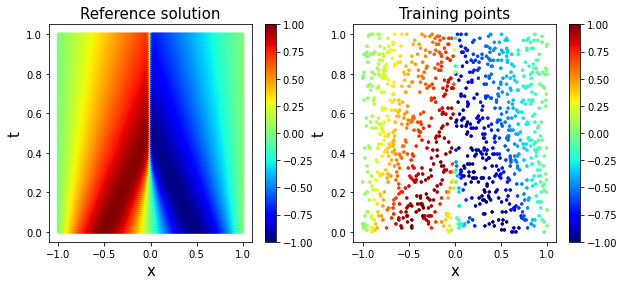

In [19]:
fig = plt.figure(figsize=[10,4])
axes = fig.subplots(1,2, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_data[:, 0:1], X_data[:, 1:2], c=u_data, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].scatter(X_data[:, 0:1], X_data[:, 1:2], c=u_data, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('Training points', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])

### 1. Random forest regression

Training error by Random forest:  0.02221307976557973
Testing error by Random forest:  0.061925301013669096


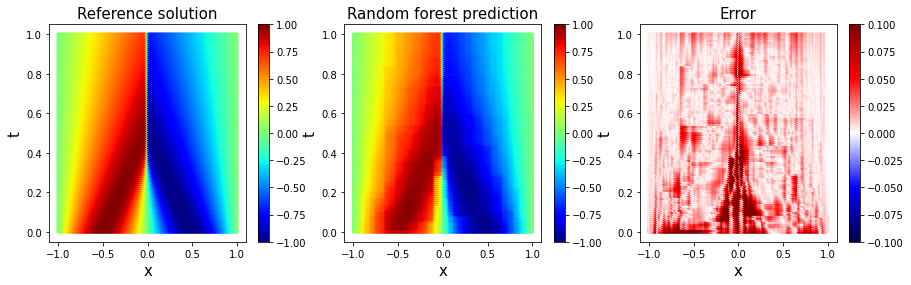

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

RF = RandomForestRegressor(max_depth=None, random_state=0,max_features="auto",n_estimators=100)
RFfit=RF.fit(X_data, np.ravel(u_data))

u_data_pred_RF = RFfit.predict(X_data)
u_star_pred_RF = RFfit.predict(X_star)     

print("Training error by Random forest: ", np.linalg.norm(u_data_pred_RF.flatten() - u_data.flatten())/np.linalg.norm(u_data.flatten()))
print("Testing error by Random forest: ", np.linalg.norm(u_star_pred_RF.flatten() - u_star.flatten())/np.linalg.norm(u_star.flatten()))

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star_pred_RF, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('Random forest prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=np.abs(u_star.flatten()-u_star_pred_RF.flatten()), cmap='seismic', vmax=0.1, vmin=-0.1, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

### 2. Gradient Boosting regression

Training error by Gradient boosting:  2.4930136407855184e-08
Testing error by Gradient boosting:  0.08036391630836855


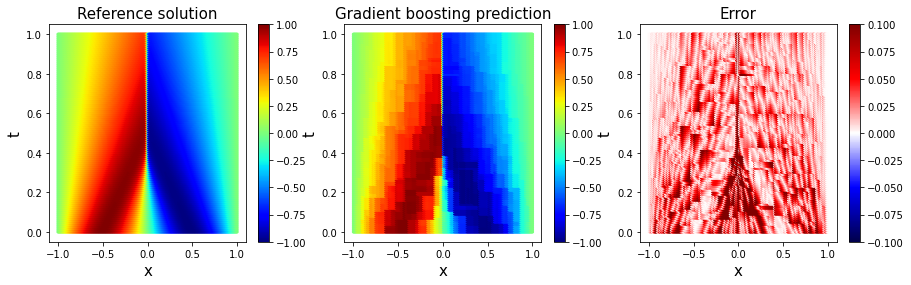

In [21]:
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

GB = GradientBoostingRegressor(max_depth=None, random_state=0,max_features="auto",n_estimators=200)
GBfit=GB.fit(X_data, np.ravel(u_data))
GradientBoostingRegressor(random_state=0)

u_data_pred_GB=GB.predict(X_data)
u_star_pred_GB=GB.predict(X_star)

print("Training error by Gradient boosting: ", np.linalg.norm(u_data_pred_GB.flatten() - u_data.flatten())/np.linalg.norm(u_data.flatten()))
print("Testing error by Gradient boosting: ", np.linalg.norm(u_star_pred_GB.flatten() - u_star.flatten())/np.linalg.norm(u_star.flatten()))

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star_pred_GB, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('Gradient boosting prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=np.abs(u_star.flatten()-u_star_pred_GB.flatten()), cmap='seismic', vmax=0.1, vmin=-0.1, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

### 3. Gaussian process

Training error by Gaussian process:  3.593916199142675e-07
Testing error by Gaussian process:  0.0151922039181112


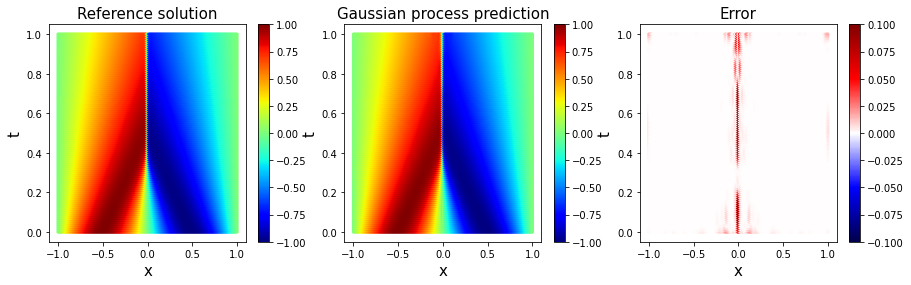

In [22]:
# !pip install pylibkriging
import pylibkriging as gp
from sklearn.metrics import mean_squared_error

GPfit = gp.Kriging(-np.abs(np.ravel(u_data)), np.abs(X_data), "gauss")

u_data_pred_GP = GPfit.predict(np.abs(X_data), True, False, False)[0][:,0]
u_data_pred_GP = np.sign(X_data[:,0]) * u_data_pred_GP

u_star_pred_GP = []
i=0
while i< X_star.shape[0]: # seq predict /1000 to not overload RAM limit
    X_star_i = X_star[np.arange(i,min(X_star.shape[0], i+1000)), ]
    u_star_pred_GP = np.append(u_star_pred_GP, GPfit.predict(np.abs(X_star_i), True, False, False)[0][:,0]*np.sign(X_star_i[:,0]))
    i=i+1000
    
print("Training error by Gaussian process: ", np.linalg.norm(u_data_pred_GP.flatten() - u_data.flatten())/np.linalg.norm(u_data.flatten()))
print("Testing error by Gaussian process: ", np.linalg.norm(u_star_pred_GP.flatten() - u_star.flatten())/np.linalg.norm(u_star.flatten()))

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star_pred_GP, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('Gaussian process prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=np.abs(u_star.flatten()-u_star_pred_GP.flatten()), cmap='seismic', vmax=0.1, vmin=-0.1, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

### 4. Data-driven Neural networks

Training error by Neural networks:  0.010537899593718253
Testing error by Neural networks:  0.01849518652396237


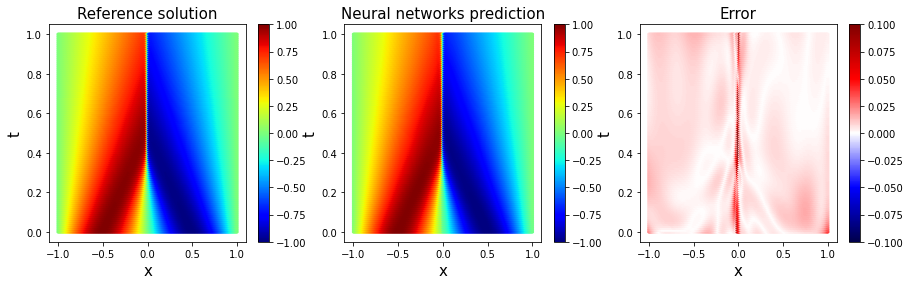

In [23]:
layers = [2] + [50]*4 + [1]
NN = tf.keras.Sequential()
NN.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
for i in range(1, len(layers) - 1):
    NN.add(tf.keras.layers.Dense(layers[i], activation=tf.nn.tanh, kernel_initializer="glorot_normal"))
NN.add(tf.keras.layers.Dense(layers[-1], activation=None, kernel_initializer="glorot_normal"))

NN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError())
NN.fit(X_data, u_data,epochs=1000,verbose=0)

u_data_pred_NN = NN.predict(X_data)
u_star_pred_NN = NN.predict(X_star)

print("Training error by Neural networks: ", np.linalg.norm(u_data_pred_NN.flatten() - u_data.flatten())/np.linalg.norm(u_data.flatten()))
print("Testing error by Neural networks: ", np.linalg.norm(u_star_pred_NN.flatten() - u_star.flatten())/np.linalg.norm(u_star.flatten()))

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star_pred_NN, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('Neural networks prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=np.abs(u_star.flatten()-u_star_pred_NN.flatten()), cmap='seismic', vmax=0.1, vmin=-0.1, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

## What if we only dispose the data at the boundary and initial condition?

#### Define the training points

In [28]:
# Define the initial condition
idx_init = np.where(X_star[:, 1]==0)[0]
X_init = X_star[idx_init]
u_init = -np.sin(pi*X_init[:, 0:1])

# Define the boundary condition
idx_bc = np.where((X_star[:, 0]==1.0)|(X_star[:, 0]==-1.0))[0]
X_bc = X_star[idx_bc]
u_bc = np.zeros((X_bc.shape[0], 1))

# Define the training points
X_data = np.concatenate((X_init, X_bc), axis=0)
u_data = np.concatenate((u_init, u_bc), axis=0)

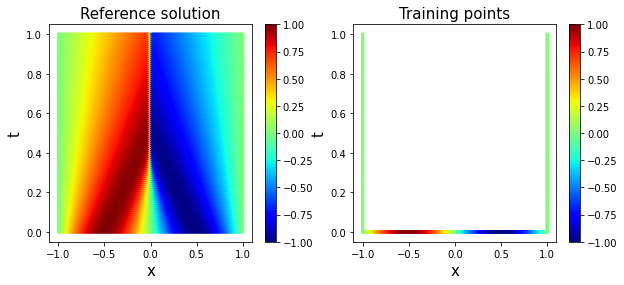

In [29]:
fig = plt.figure(figsize=[10,4])
axes = fig.subplots(1,2, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_data[:, 0:1], X_data[:, 1:2], c=u_data, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].scatter(X_data[:, 0:1], X_data[:, 1:2], c=u_data, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('Training points', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])

#### <font color='red'>Exercise: </font> Use Random forest, Gradient boosting, Gaussian Process, and Neural networks to approximate the solution

In [ ]:
RF = ... # TO IMPLEMENT


In [ ]:
GB = ... #TO IMPLEMENT


In [ ]:
GPfit = ... #TO IMPLEMENT


In [ ]:
NN = ... # TO IMPLEMENT


#### Solution

Training error by Random forest:  0.0050646671022096315
Testing error by Random forest:  0.5872864156659127


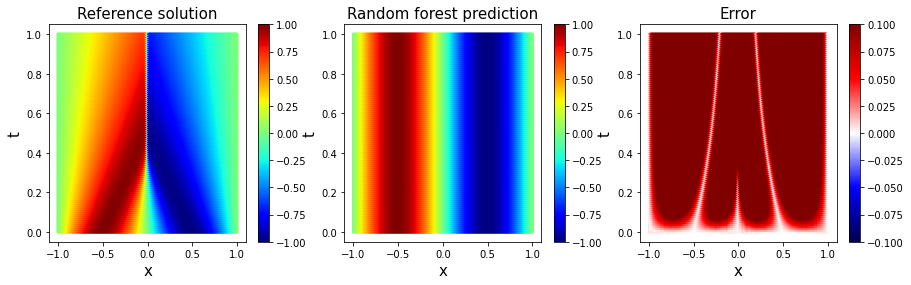

In [30]:
RF = RandomForestRegressor(max_depth=None, random_state=0,max_features="auto",n_estimators=100)
RFfit=RF.fit(X_data, np.ravel(u_data))

u_data_pred_RF = RFfit.predict(X_data)
u_star_pred_RF = RFfit.predict(X_star)     

print("Training error by Random forest: ", np.linalg.norm(u_data_pred_RF.flatten() - u_data.flatten())/np.linalg.norm(u_data.flatten()))
print("Testing error by Random forest: ", np.linalg.norm(u_star_pred_RF.flatten() - u_star.flatten())/np.linalg.norm(u_star.flatten()))

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star_pred_RF, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('Random forest prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=np.abs(u_star.flatten()-u_star_pred_RF.flatten()), cmap='seismic', vmax=0.1, vmin=-0.1, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

Training error by Gradient boosting:  2.79398163354128e-08
Testing error by Gradient boosting:  0.5874745074829958


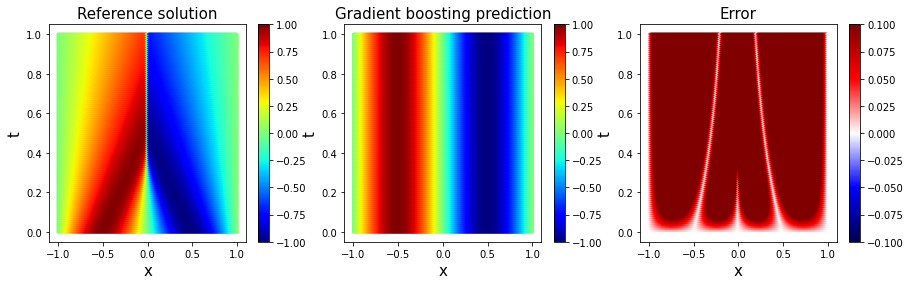

In [32]:
GB = GradientBoostingRegressor(max_depth=None, random_state=0,max_features="auto",n_estimators=200)
GBfit=GB.fit(X_data, np.ravel(u_data))
GradientBoostingRegressor(random_state=0)

u_data_pred_GB=GB.predict(X_data)
u_star_pred_GB=GB.predict(X_star)

print("Training error by Gradient boosting: ", np.linalg.norm(u_data_pred_GB.flatten() - u_data.flatten())/np.linalg.norm(u_data.flatten()))
print("Testing error by Gradient boosting: ", np.linalg.norm(u_star_pred_GB.flatten() - u_star.flatten())/np.linalg.norm(u_star.flatten()))

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star_pred_GB, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('Gradient boosting prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=np.abs(u_star.flatten()-u_star_pred_GB.flatten()), cmap='seismic', vmax=0.1, vmin=-0.1, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

Training error by Gaussian process:  1.647953489380215e-07
Testing error by Gaussian process:  0.5860252481510873


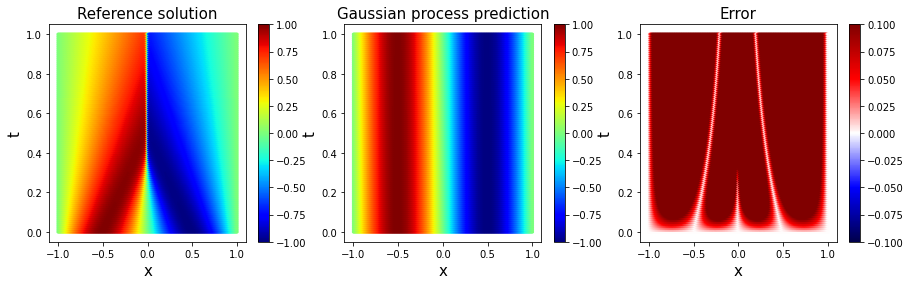

In [35]:
GPfit = gp.Kriging(-np.abs(np.ravel(u_data)), np.abs(X_data), "gauss")

u_data_pred_GP = GPfit.predict(np.abs(X_data), True, False, False)[0][:,0]
u_data_pred_GP = np.sign(X_data[:,0]) * u_data_pred_GP

u_star_pred_GP = []
i=0
while i< X_star.shape[0]: # seq predict /1000 to not overload RAM limit
    X_star_i = X_star[np.arange(i,min(X_star.shape[0], i+1000)), ]
    u_star_pred_GP = np.append(u_star_pred_GP, GPfit.predict(np.abs(X_star_i), True, False, False)[0][:,0]*np.sign(X_star_i[:,0]))
    i=i+1000
    
print("Training error by Gaussian process: ", np.linalg.norm(u_data_pred_GP.flatten() - u_data.flatten())/np.linalg.norm(u_data.flatten()))
print("Testing error by Gaussian process: ", np.linalg.norm(u_star_pred_GP.flatten() - u_star.flatten())/np.linalg.norm(u_star.flatten()))

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star_pred_GP, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('Gaussian process prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=np.abs(u_star.flatten()-u_star_pred_GP.flatten()), cmap='seismic', vmax=0.1, vmin=-0.1, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])

Training error by Neural networks:  0.07077130758533193
Testing error by Neural networks:  0.7991432115945472


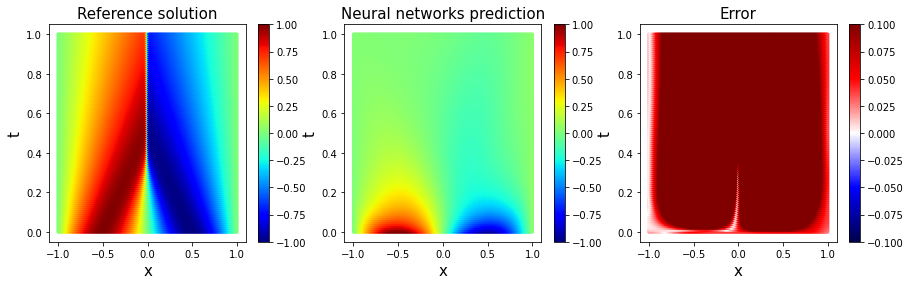

In [36]:
layers = [2] + [50]*4 + [1]
NN = tf.keras.Sequential()
NN.add(tf.keras.layers.InputLayer(input_shape=(layers[0],)))
for i in range(1, len(layers) - 1):
    NN.add(tf.keras.layers.Dense(layers[i], activation=tf.nn.tanh, kernel_initializer="glorot_normal"))
NN.add(tf.keras.layers.Dense(layers[-1], activation=None, kernel_initializer="glorot_normal"))

NN.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.MeanSquaredError())
NN.fit(X_data, u_data,epochs=1000,verbose=0)

u_data_pred_NN = NN.predict(X_data)
u_star_pred_NN = NN.predict(X_star)

print("Training error by Neural networks: ", np.linalg.norm(u_data_pred_NN.flatten() - u_data.flatten())/np.linalg.norm(u_data.flatten()))
print("Testing error by Neural networks: ", np.linalg.norm(u_star_pred_NN.flatten() - u_star.flatten())/np.linalg.norm(u_star.flatten()))

fig = plt.figure(figsize=[15,4])
axes = fig.subplots(1,3, sharex=False, sharey=False)
img1 = axes[0].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star, cmap='jet', vmax=1, vmin=-1, s=5)
axes[0].set_title('Reference solution', fontsize=15)
axes[0].set_xlabel('x', fontsize=15)
axes[0].set_ylabel('t', fontsize=15)
plt.colorbar(img1, ax=axes[0])
img2 = axes[1].scatter(X_star[:, 0:1], X_star[:, 1:2], c=u_star_pred_NN, cmap='jet', vmax=1, vmin=-1, s=5)
axes[1].set_title('Neural networks prediction', fontsize=15)
axes[1].set_xlabel('x', fontsize=15)
axes[1].set_ylabel('t', fontsize=15)
plt.colorbar(img2, ax=axes[1])
img3 = axes[2].scatter(X_star[:, 0:1], X_star[:, 1:2], c=np.abs(u_star.flatten()-u_star_pred_NN.flatten()), cmap='seismic', vmax=0.1, vmin=-0.1, s=5)
axes[2].set_title('Error', fontsize=15)
axes[2].set_xlabel('x', fontsize=15)
axes[2].set_ylabel('t', fontsize=15)
plt.colorbar(img3, ax=axes[2])